In [ ]:
#| default_exp visuals

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
import anndata as ad

In [ ]:
from allos.readers_tests import *
from allos.preprocessing import subset_common_cells, transfer_obs


In [ ]:
combined_mouse_data = process_mouse_data()


🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
import scanpy as sc
from allos.preprocessing import get_sot_gene_matrix

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 12561 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


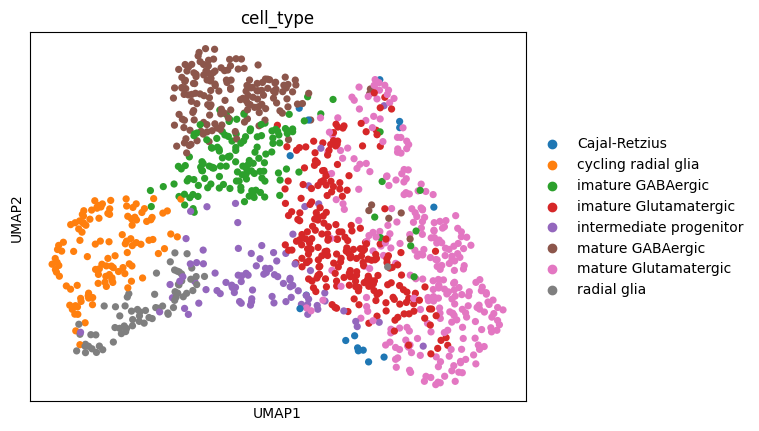

In [ ]:
mouse_data_gene = get_sot_gene_matrix(combined_mouse_data)
sc.pp.normalize_total(mouse_data_gene,target_sum = 1e6)
sc.pp.log1p(mouse_data_gene)
sc.pp.neighbors(mouse_data_gene)
sc.tl.umap(mouse_data_gene)
sc.pl.umap(mouse_data_gene, color = 'cell_type')


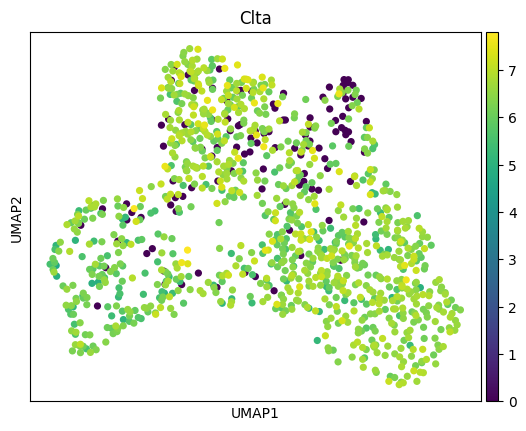

In [ ]:
sc.pl.umap(mouse_data_gene, color = 'Clta')

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 31986 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


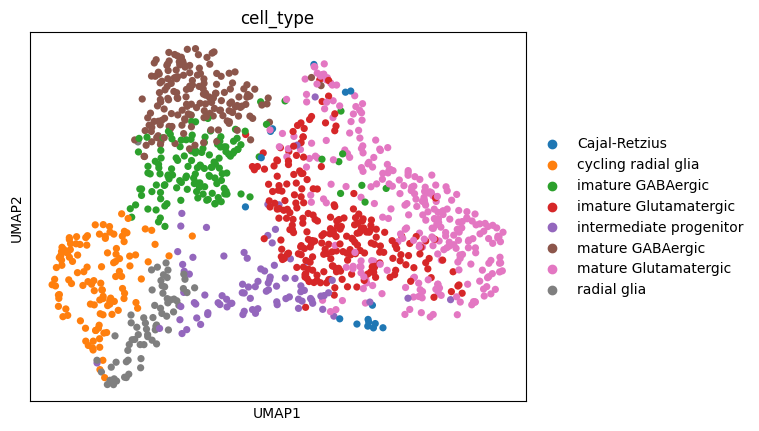

In [ ]:
sc.pp.normalize_total(combined_mouse_data,target_sum = 1e6)
sc.pp.log1p(combined_mouse_data)
sc.pp.neighbors(combined_mouse_data)
sc.tl.umap(combined_mouse_data)
sc.pl.umap(combined_mouse_data, color = 'cell_type')

In [ ]:
#| export
import scanpy as sc

def plot_transcripts(adata, gene_id=None, transcripts=None):
    """
    Plot the UMAP with the specified transcripts or transcripts associated with the given gene ID.
    
    Parameters:
    -----------
    adata : AnnData
        The annotated data matrix.
    gene_id : str, optional
        The gene ID for which to find and plot associated transcripts. 
        Ignored if `transcripts` is provided.
    transcripts : list of str, optional
        A list of transcript IDs to plot. If provided, `gene_id` is ignored.
    
    Returns:
    --------
    None
        Displays the UMAP plot colored by the specified transcripts.
    """
    if transcripts is None:
        if gene_id is None:
            raise ValueError("Either `gene_id` or `transcripts` must be provided.")
        # Select transcripts associated with the provided gene ID
        transcripts = adata[:, adata.var['geneId'] == gene_id].var.index.to_list()
    
    # Plot UMAP
    sc.pl.umap(adata, color=transcripts)


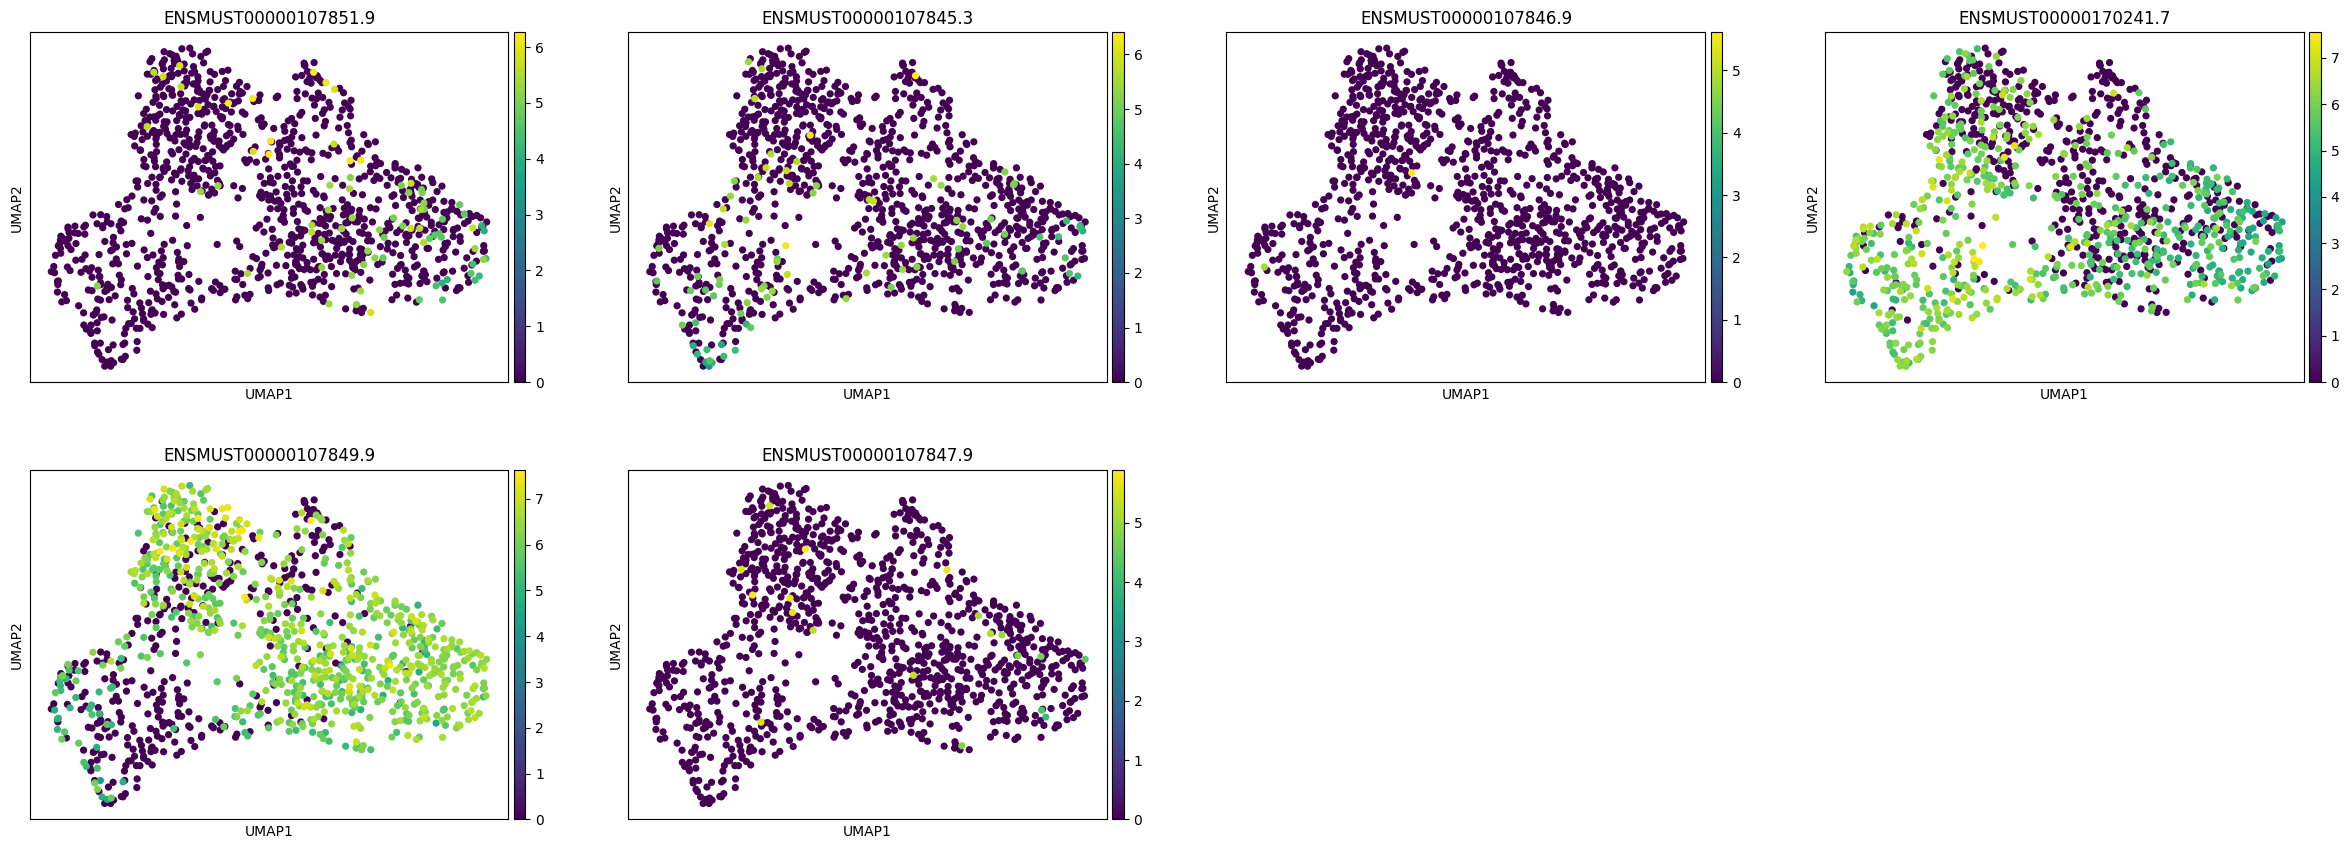

In [ ]:
plot_transcripts(combined_mouse_data, gene_id='Clta')

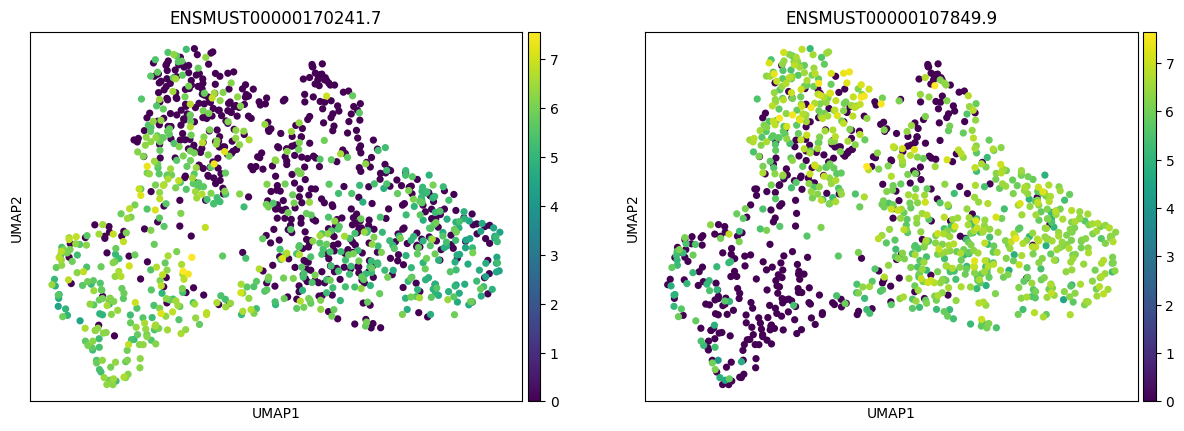

In [ ]:
plot_transcripts(combined_mouse_data, transcripts=['ENSMUST00000170241.7','ENSMUST00000107849.9'])

In [ ]:
#| export
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import norm
import matplotlib.pyplot as plt

###############################################################################
# 1) Helper: approximate "hpi" bandwidth (1D) 
#    (Here we do a simple Silverman or similar rule-of-thumb, for demonstration)
###############################################################################

def normal_reference_bandwidth(x):
    """
    Approximate the normal-reference (Silverman's) bandwidth for 1D data.
    R's ks::hpi uses a more sophisticated pilot estimation, but this is
    often 'close enough' for large data.
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = np.std(x, ddof=1)
    # Silverman’s rule
    bw = 0.9 * min(sigma, iqr / 1.34) * n ** (-1 / 5)
    return bw


###############################################################################
# 2) The core wkde2d function 
#    (mirroring your R code's logic for x, y, w)
###############################################################################

def wkde2d(x, y, w=None, h=None, adjust=1.0, n=100, lims=None):
    """
    Python equivalent of your R 'wkde2d' function:
      x, y: coordinates (1D arrays) for each observation.
      w   : weight vector (same length as x, y).
      h   : tuple or scalar for bandwidth in the x/y directions (if None, use approximate).
      adjust: bandwidth adjustment scalar.
      n   : number of grid points in each direction.
      lims: [x_min, x_max, y_min, y_max] to define the grid.
    Returns a dict with {'x': gx, 'y': gy, 'z': Z}, analogous to R’s list(x=..., y=..., z=...).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if w is None:
        # If no weight vector given, assume uniform weights
        w = np.ones_like(x)
    else:
        w = np.asarray(w, dtype=float)

    if len(x) != len(y) or len(x) != len(w):
        raise ValueError("x, y, w must all have the same length")

    # Default lims: ranges of x,y
    if lims is None:
        lims = [x.min(), x.max(), y.min(), y.max()]
    if len(lims) != 4:
        raise ValueError("lims must be [x_min, x_max, y_min, y_max]")

    # If bandwidths not provided, estimate them
    if h is None:
        hx = normal_reference_bandwidth(x)
        hy = normal_reference_bandwidth(y)
        h = (hx, hy)
    else:
        # If user passes scalar, apply to both x and y
        if np.isscalar(h):
            h = (float(h), float(h))
        else:
            # Ensure is length-2
            h = tuple(h)
    # Apply the "adjust" factor
    h = (h[0] * adjust, h[1] * adjust)

    # Build the grid
    gx = np.linspace(lims[0], lims[1], n)
    gy = np.linspace(lims[2], lims[3], n)

    # Outer differences for x and y
    # shape: (n, len(x))
    ax = (gx[:, None] - x[None, :]) / h[0]
    ay = (gy[:, None] - y[None, :]) / h[1]

    # Compute normal pdf at each (grid, data) difference
    # norm.pdf(ax) is 1/sqrt(2π)*exp(-ax^2/2)
    # We'll just do it by hand for speed:
    fx = np.exp(-0.5 * ax**2) / np.sqrt(2.0 * np.pi)
    fy = np.exp(-0.5 * ay**2) / np.sqrt(2.0 * np.pi)

    # Multiply each data column by w
    w = w[None, :]  # shape => (1, len(x))
    fxw = fx * w
    fyw = fy * w

    # Now do the matrix multiplication: R’s tcrossprod(M1, M2) = M1 %*% t(M2)
    # shape => (n, n)
    z = fxw.dot(fyw.T)

    # Divide by sum of w, and the bandwidth product
    Z = z / (w.sum() * h[0] * h[1])

    return {"x": gx, "y": gy, "z": Z}


###############################################################################
# 3) Mapping per-cell densities via "findInterval"-like logic
###############################################################################

def get_dens(points, dens):
    """
    Map each 2D point to the approximate density in `dens["z"]`.
    This mimics the R code that uses findInterval.
       points: shape (n_cells, 2)
       dens  : dict with 'x', 'y', 'z', from wkde2d
    Returns a 1D np.array of densities (one per row in points).
    """
    xgrid = dens["x"]
    ygrid = dens["y"]
    Z     = dens["z"]  # shape => (len(xgrid), len(ygrid))

    # For each coordinate, find closest bin index.
    # np.searchsorted(xgrid, xp) finds where xp would be inserted;
    # subtract 1 so it behaves like R findInterval (the left bin).
    ix = np.searchsorted(xgrid, points[:, 0]) - 1
    iy = np.searchsorted(ygrid, points[:, 1]) - 1

    # Clamp to valid range
    ix = np.clip(ix, 0, len(xgrid) - 1)
    iy = np.clip(iy, 0, len(ygrid) - 1)

    return Z[ix, iy]


###############################################################################
# 4) Putting it all together in a mini "scanpy-like" usage:
###############################################################################

def calculate_density(adata, feature, basis="umap", adjust=1.0, map_to_cells=True):
    """
    1) Extract coordinates from adata.obsm[f"X_{basis}"].
    2) Extract expression vector for `feature`.
    3) Run the weighted KDE.
    4) If map_to_cells=True, return per-cell densities; else return the full grid.
    """
    # (a) get the 2D embedding:
    if f"X_{basis}" not in adata.obsm:
        raise ValueError(f"AnnData has no .obsm['X_{basis}']")

    coords = adata.obsm[f"X_{basis}"]  # shape => (n_cells, 2)
    if coords.shape[1] != 2:
        raise ValueError(f"Embedding {basis} must be 2D, found shape {coords.shape}")

    # (b) get weights w from the feature (assuming it's in adata.var_names)
    # or if it’s an obs-level feature, look in adata.obs:
    if feature in adata.var_names:
        # For gene expression, we can do:
        #   w = adata[:, feature].X.A1  if X is sparse 
        #   or  adata[:, feature].X if it’s dense
        #   or  adata.obs_vector(feature)
        # Below tries adata.obs_vector first:
        w = adata.obs_vector(feature)
    elif feature in adata.obs.columns:
        w = adata.obs[feature].values
    else:
        raise ValueError(f"Feature '{feature}' not found in adata.var_names or adata.obs.columns")

    # (c) compute the weighted 2D density:
    dens = wkde2d(
        x=coords[:, 0],
        y=coords[:, 1],
        w=w,
        adjust=adjust,
        n=200,         # or 100, your choice
        lims=None      # or specify [xmin, xmax, ymin, ymax]
    )

    # (d) either return the raw grid or map per-cell
    if map_to_cells:
        return get_dens(coords, dens)
    else:
        return dens


def plot_density(adata, feature, basis="umap", adjust=1.0, cmap="viridis"):
    """
    Simple scatterplot colored by the weighted density of `feature`.
    """
    # 1) Get per-cell densities
    z = calculate_density(adata, feature, basis=basis, adjust=adjust, map_to_cells=True)
    coords = adata.obsm[f"X_{basis}"]

    # 2) Plot
    plt.scatter(coords[:, 0], coords[:, 1], c=z, s=5, cmap=cmap)
    plt.title(f"Density: {feature}")
    plt.colorbar(label="Density")
    plt.xlabel(f"{basis}1")
    plt.ylabel(f"{basis}2")
    plt.tight_layout()
    plt.show()


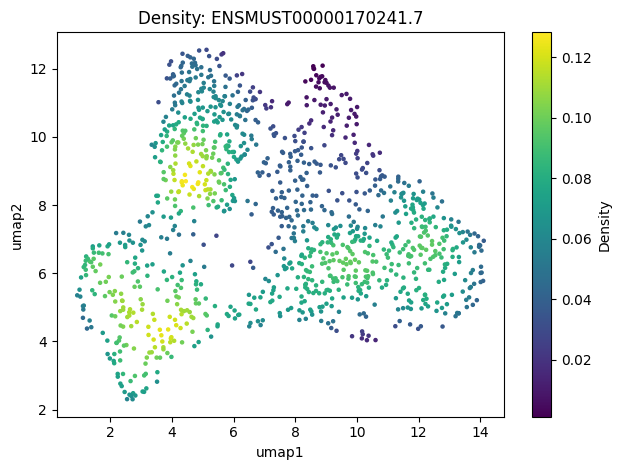

In [ ]:
plot_density(combined_mouse_data, 'ENSMUST00000170241.7', basis= 'umap')

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt

def plot_density_multi(adata, features, basis="umap", adjust=1.0, cmap="viridis"):
    """
    Plot one or multiple features' density on the specified 2D embedding.
    - If 'features' is a single string, makes one subplot.
    - If 'features' is a list of strings, makes multiple side-by-side subplots.
    """
    # 1) Ensure we have a list
    if isinstance(features, str):
        features = [features]
    n_feats = len(features)

    # 2) Prepare subplots
    if n_feats == 0:
        raise ValueError("No features provided.")
    elif n_feats == 1:
        fig, ax_arr = plt.subplots(1, 1, figsize=(6, 5))
        ax_arr = [ax_arr]  # so we can iterate
    else:
        fig, ax_arr = plt.subplots(1, n_feats, figsize=(6 * n_feats, 5), 
                                   sharex=True, sharey=True)
    
    # 3) Extract the embedding
    if f"X_{basis}" not in adata.obsm:
        raise ValueError(f"AnnData has no .obsm['X_{basis}']")
    coords = adata.obsm[f"X_{basis}"]
    if coords.shape[1] != 2:
        raise ValueError(f"Embedding {basis} must be 2D, found shape {coords.shape}")

    # 4) For each feature, calculate density and plot
    for i, feat in enumerate(features):
        # calculate_density is the function you provided:
        z = calculate_density(adata, feat, basis=basis, adjust=adjust, map_to_cells=True)

        # scatter plot with density as color
        sc = ax_arr[i].scatter(coords[:, 0], coords[:, 1], c=z, s=5, cmap=cmap)
        ax_arr[i].set_title(f"Density: {feat}")
        ax_arr[i].set_xlabel(f"{basis}1")
        ax_arr[i].set_ylabel(f"{basis}2")

        cbar = plt.colorbar(sc, ax=ax_arr[i], fraction=0.046, pad=0.04)
        cbar.set_label("Density", rotation=90)

    plt.tight_layout()
    plt.show()

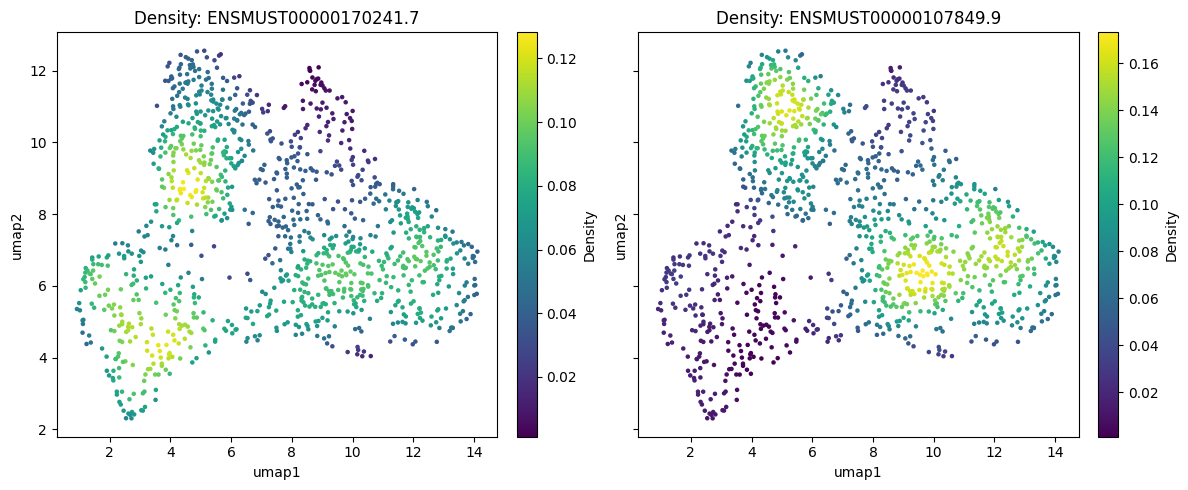

In [ ]:
plot_density_multi(
    adata=combined_mouse_data,
    features=['ENSMUST00000170241.7', 'ENSMUST00000107849.9'],
    basis='umap'
)


In [ ]:
#| export

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_transcript_exspression_dotplot(adata, gene_id, cell_labels_column='cell_type', top_n=5):
    """
    Plot isoform expression for a selected gene across cell types,
    with dot color = average expression, and dot size = percent
    of cells expressing. Two legends: a colorbar for average
    expression, and a bubble-size legend for pct_expressing.

    DIFFERENT LAYOUT APPROACH:
    - We use a single figure+axes with plt.tight_layout(rect=[...])
      to reserve space on the right. 
    - We place the bubble-size legend as an "in-figure" legend
      using bbox_to_anchor, so it won't be cut off.
    """

    sns.set_theme(style='white', context='notebook')

    # ----------------------------------------------------
    # 1. Identify isoforms for the gene
    # ----------------------------------------------------
    isoforms = adata.var[adata.var['geneId'] == gene_id].index
    if len(isoforms) == 0:
        print(f"No isoforms found for gene ID: {gene_id}")
        return

    # (Optional) keep only top_n isoforms by overall average
    if top_n and len(isoforms) > top_n:
        overall_expr = adata.to_df()[isoforms].mean()
        isoforms = overall_expr.sort_values(ascending=False).head(top_n).index

    # ----------------------------------------------------
    # 2. Average expression by cell type
    # ----------------------------------------------------
    avg_expr_list = []
    for iso in isoforms:
        means = adata.to_df()[iso].groupby(adata.obs[cell_labels_column], observed=False).mean()
        df_means = pd.DataFrame({
            cell_labels_column: means.index,
            'average_expression': means.values
        })
        df_means['isoform'] = iso
        avg_expr_list.append(df_means)
    avg_expr_df = pd.concat(avg_expr_list, ignore_index=True)

    # ----------------------------------------------------
    # 3. Percent of cells expressing each isoform
    # ----------------------------------------------------
    pct_expr_list = []
    for iso in isoforms:
        pct_expressing = adata.to_df()[iso]\
            .groupby(adata.obs[cell_labels_column], observed=False)\
            .apply(lambda x: (x > 0).mean() * 100)

        df_pct = pd.DataFrame({
            cell_labels_column: pct_expressing.index,
            'pct_expressing': pct_expressing.values
        })
        df_pct['isoform'] = iso
        pct_expr_list.append(df_pct)
    pct_expr_df = pd.concat(pct_expr_list, ignore_index=True)

    # ----------------------------------------------------
    # 4. Merge the average and pct data
    # ----------------------------------------------------
    plot_df = pd.merge(avg_expr_df, pct_expr_df,
                       on=['isoform', cell_labels_column],
                       how='left')

    # Drop columns that are all NaN or all zero
    plot_df.dropna(axis=1, how='all', inplace=True)
    numeric_cols = plot_df.select_dtypes(include=[np.number]).columns
    all_zero = (plot_df[numeric_cols] == 0).all(axis=0)
    plot_df.drop(columns=all_zero[all_zero].index, inplace=True)

    # ----------------------------------------------------
    # 5. Clean labels & drop blank cell types
    # ----------------------------------------------------
    plot_df['display_isoform'] = plot_df['isoform'].astype(str)
    plot_df['gene_isoform'] = gene_id + "–" + plot_df['display_isoform']

    plot_df = plot_df[plot_df[cell_labels_column].astype(str).str.strip() != '']

    # ----------------------------------------------------
    # 6. Filter out cell-types / isoforms with zero sums
    # ----------------------------------------------------
    plot_df = plot_df.groupby(cell_labels_column, observed=False).filter(
        lambda grp: (grp['average_expression'].sum() > 0) or
                    (grp['pct_expressing'].sum() > 0)
    )
    plot_df = plot_df.groupby('isoform', observed=False).filter(
        lambda grp: (grp['average_expression'].sum() > 0) or
                    (grp['pct_expressing'].sum() > 0)
    )

    # ----------------------------------------------------
    # 7. Convert to categorical + remove unused
    # ----------------------------------------------------
    plot_df[cell_labels_column] = plot_df[cell_labels_column].astype('category')
    plot_df['isoform'] = plot_df['isoform'].astype('category')
    plot_df[cell_labels_column] = plot_df[cell_labels_column].cat.remove_unused_categories()
    plot_df['isoform'] = plot_df['isoform'].cat.remove_unused_categories()

    # Sort so the x-axis follows category order
    cat_order = list(plot_df[cell_labels_column].cat.categories)
    plot_df[cell_labels_column] = plot_df[cell_labels_column].cat\
        .reorder_categories(cat_order, ordered=True)
    plot_df.sort_values(by=cell_labels_column, inplace=True)

    # ----------------------------------------------------
    # 8. Create figure & axes (no constrained layout)
    # ----------------------------------------------------
    fig_width = 25
    fig_height = max(5, plot_df['isoform'].nunique() * 0.8)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # We'll use tight_layout with rect=... to keep space on the right
    plt.tight_layout(rect=[0, 0, 0.78, 1])  # leave 22% on right side

    # ----------------------------------------------------
    # 9. Scatterplot: hue=average_expr, size=pct_expr
    # ----------------------------------------------------
    vmin = plot_df['average_expression'].min() if 'average_expression' in plot_df else 0
    vmax = plot_df['average_expression'].max() if 'average_expression' in plot_df else 1

    scatter = sns.scatterplot(
        data=plot_df,
        x=cell_labels_column,
        y='gene_isoform',
        hue='average_expression',     # color scale
        size='pct_expressing',        # bubble size
        palette='viridis',
        sizes=(50, 300),
        edgecolor='white',
        alpha=0.9,
        legend=False,  # We'll add custom legends
        hue_norm=plt.Normalize(vmin, vmax),
        ax=ax
    )

    ax.set_title(f'Differential Isoform Expression for {gene_id}', fontsize=16, pad=20)
    ax.set_xlabel('Cell Type', fontsize=13)
    ax.set_ylabel('Gene–Isoform', fontsize=13)
    sns.despine(ax=ax)

    # ----------------------------------------------------
    # 10. Color bar for average_expression
    # ----------------------------------------------------
    if 'average_expression' in plot_df:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.02)
        cbar.set_label('Average Expression', fontsize=12)

    # ----------------------------------------------------
    # 11. Bubble-size legend for pct_expressing
    #     We'll place it inside the figure to the right
    # ----------------------------------------------------
    if 'pct_expressing' in plot_df:
        size_bins = [0, 25, 50, 75, 100]
        size_handles = []
        for val in size_bins:
            # Map 0..100 to size range 50..300
            marker_size = np.interp(val, [0, 100], [50, 300])
            size_handles.append(
                plt.scatter([], [], s=marker_size, color='gray',
                            alpha=0.9, edgecolor='white')
            )
        size_labels = [f"{int(val)}%" for val in size_bins]

        # Place bubble legend in the middle-right
        legend_size = ax.legend(
            size_handles,
            size_labels,
            title='Pct. Expressing',
            loc='center left',         # place vertically centered
            bbox_to_anchor=(1.08, 0.75),
            frameon=False,
            fontsize=10,
            title_fontsize=12
        )
        ax.add_artist(legend_size)

    # ----------------------------------------------------
    # 12. Final touches: rotate x labels, show plot
    # ----------------------------------------------------
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.show()




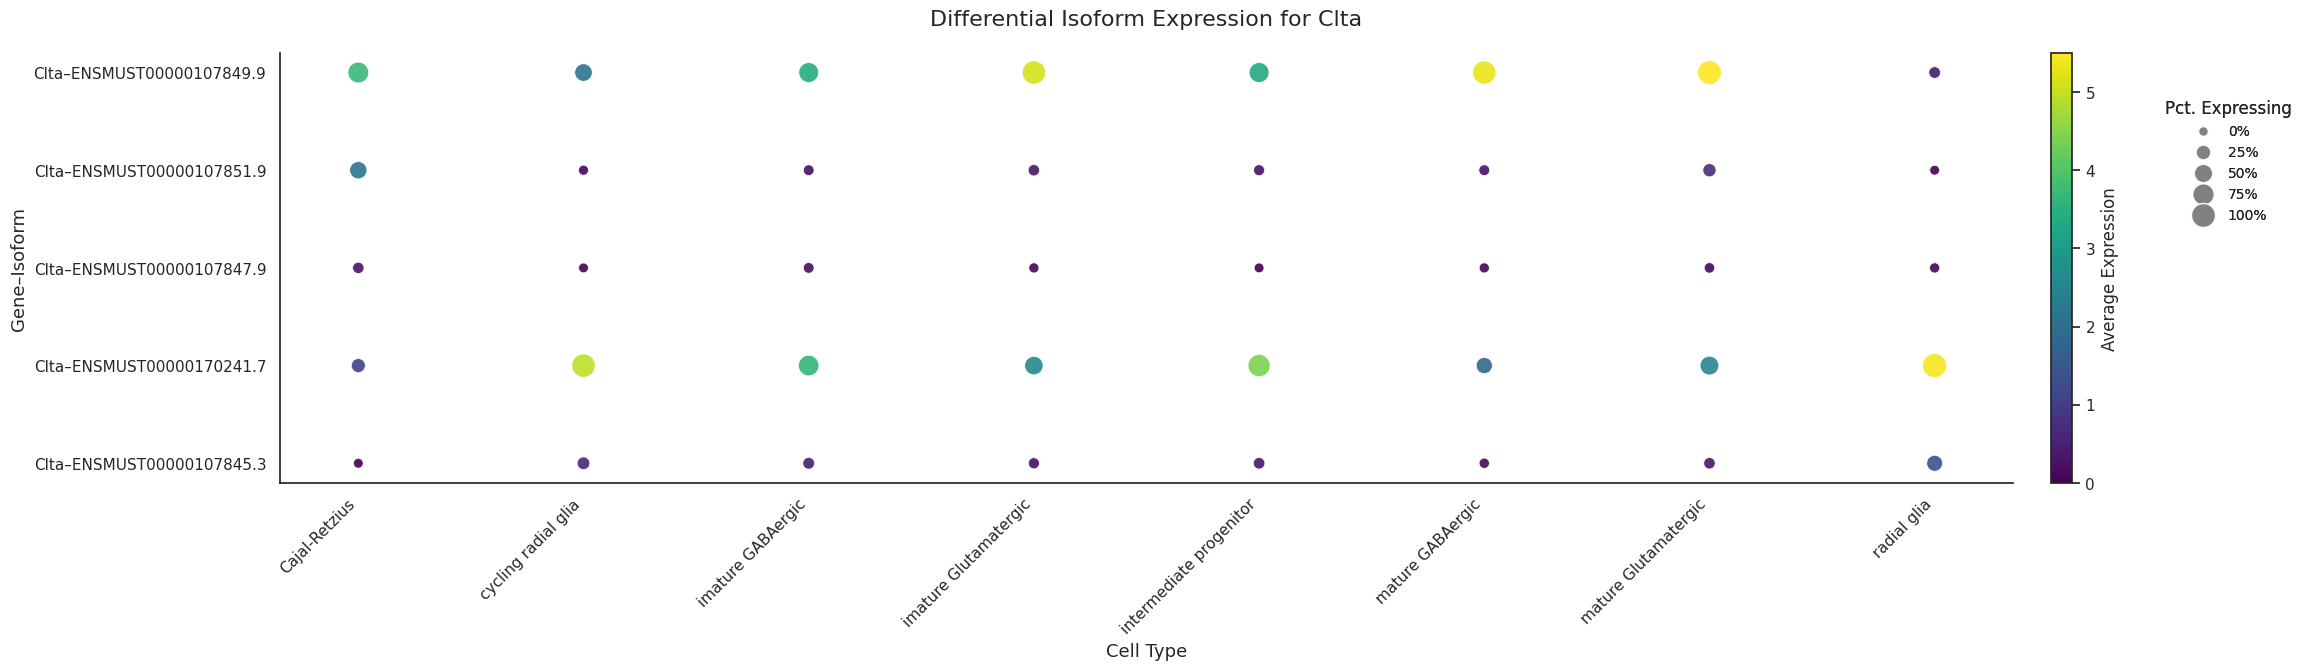

In [ ]:
plot_transcript_exspression_dotplot(combined_mouse_data, gene_id='Clta', top_n=5)

In [ ]:
#| export
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_transcript_expression_violin(
    adata,
    gene_id,
    cell_labels_column='cell_type',
    top_n=5,
    figsize_per_isoform=(4, 4)
):
    """
    Plot isoform expression for a selected gene across cell types,
    using violin plots (with each cell's expression as a point).

    Parameters
    ----------
    adata : AnnData
        Single-cell AnnData object with .obs (cells) and .var (features).
    gene_id : str
        The gene ID to filter isoforms by (adata.var['geneId']).
    cell_labels_column : str
        Column name in adata.obs specifying the cell type or cluster label.
    top_n : int or None
        If not None, keeps only the top-n isoforms by overall mean expression.
    figsize_per_isoform : tuple
        Width and height (in inches) for each isoform subplot.
    """

    sns.set_theme(style='white', context='notebook')
    
    # ----------------------------------------------------
    # 1. Identify isoforms for the gene
    # ----------------------------------------------------
    isoforms = adata.var[adata.var['geneId'] == gene_id].index
    if len(isoforms) == 0:
        print(f"No isoforms found for gene ID: {gene_id}")
        return

    # (Optional) keep only top_n isoforms by overall average
    if top_n and len(isoforms) > top_n:
        overall_expr = adata.to_df()[isoforms].mean()
        isoforms = overall_expr.sort_values(ascending=False).head(top_n).index

    # ----------------------------------------------------
    # 2. Collect expressions in a "long" DataFrame
    #    with columns: [cell_type, isoform, expression]
    # ----------------------------------------------------
    expr_df = adata.to_df()[isoforms].copy()
    expr_df[cell_labels_column] = adata.obs[cell_labels_column].values

    # Melt so that each row = one cell's expression for one isoform
    plot_df = expr_df.melt(
        id_vars=cell_labels_column, 
        var_name='isoform', 
        value_name='expression'
    )

    # Remove any cells that have an empty label
    plot_df = plot_df[plot_df[cell_labels_column].astype(str).str.strip() != '']
    
    # Remove any isoform or cell-type with zero expression across all cells.
    # Explicitly pass observed=False to retain the current behavior.
    plot_df = plot_df.groupby('isoform', observed=False).filter(lambda g: g['expression'].sum() > 0)
    plot_df = plot_df.groupby(cell_labels_column, observed=False).filter(lambda g: g['expression'].sum() > 0)

    # Make the cell type and isoform columns categorical (optional)
    plot_df[cell_labels_column] = plot_df[cell_labels_column].astype('category')
    plot_df['isoform'] = plot_df['isoform'].astype('category')

    # Sort categories so subplots come out in a stable order
    plot_df[cell_labels_column] = plot_df[cell_labels_column].cat.remove_unused_categories()
    plot_df['isoform'] = plot_df['isoform'].cat.remove_unused_categories()

    isoforms_used = plot_df['isoform'].cat.categories
    n_isoforms = len(isoforms_used)

    # ----------------------------------------------------
    # 3. Create subplots: one panel per isoform
    # ----------------------------------------------------
    fig_width = figsize_per_isoform[0] * n_isoforms
    fig_height = figsize_per_isoform[1]
    fig, axes = plt.subplots(
        1, n_isoforms,
        figsize=(fig_width, fig_height),
        sharey=True
    )

    # If there's only 1 isoform, wrap axes in a list for consistency
    if n_isoforms == 1:
        axes = [axes]

    # ----------------------------------------------------
    # 4. Plot each isoform's distribution using violin + strip
    # ----------------------------------------------------
    for i, iso in enumerate(isoforms_used):
        ax = axes[i]
        subset = plot_df[plot_df['isoform'] == iso]
        
        # Violin plot with updated parameters:
        # - Use density_norm='width' instead of scale='width'
        # - Set hue to cell_labels_column and legend=False to avoid deprecation warnings with palette.
        sns.violinplot(
            data=subset,
            x=cell_labels_column,
            y='expression',
            hue=cell_labels_column,
            ax=ax,
            density_norm='width',
            cut=0,
            palette='viridis',
            legend=False
        )
        
        # Strip plot (each cell as a point)
        sns.stripplot(
            data=subset,
            x=cell_labels_column,
            y='expression',
            ax=ax,
            color='k',
            size=2,
            alpha=0.6,
            dodge=True
        )
        
        ax.set_title(f"{gene_id} — {iso}", fontsize=12)
        ax.set_xlabel("")
        if i > 0:
            # Hide y label for all but the first subplot
            ax.set_ylabel("")

        # Rotate x-axis labels using plt.setp to avoid FixedLocator warnings
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # ----------------------------------------------------
    # 5. Final formatting
    # ----------------------------------------------------
    fig.suptitle(f'Violin plots of expression for {gene_id}', fontsize=14)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()



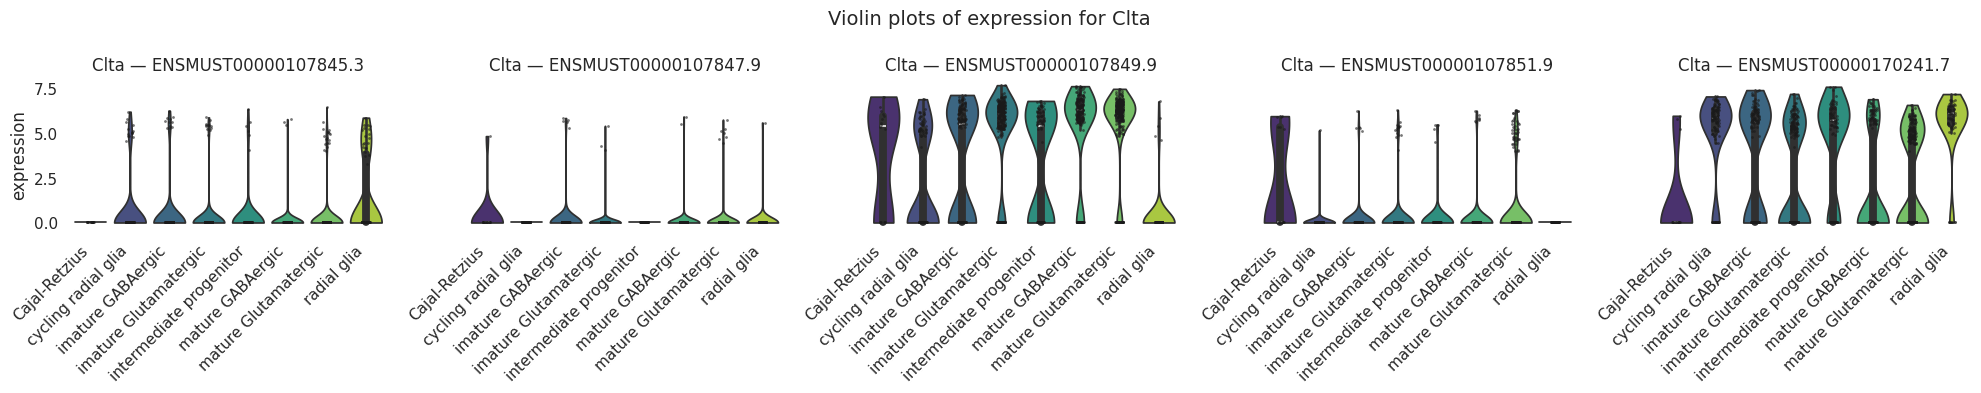

In [ ]:
plot_transcript_expression_violin(combined_mouse_data,  gene_id='Clta', top_n=5)

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import nbdev; nbdev.nbdev_export()